# 04 - Reducción de Dimensión
Este notebook documenta la Sección 5: comparar PCA, t-SNE y UMAP sobre los datos preprocesados para decidir si conviene reducir la complejidad de los modelos finales.


## 01. Carga de datos
Cargar los CSV escalados de `data/processed/` y las etiquetas ordinales para mantener la misma base que los modelos anteriores.


In [34]:
import pandas as pd
from pathlib import Path

data_dir = Path("data/processed")
X_train = pd.read_csv(data_dir / "X_train.csv")
X_test = pd.read_csv(data_dir / "X_test.csv")
y_train = pd.read_csv(data_dir / "y_train.csv").squeeze()
y_test = pd.read_csv(data_dir / "y_test.csv").squeeze()

print("Train", X_train.shape)
print("Test", X_test.shape)



Train (1477, 25)
Test (634, 25)


## 02. PCA
Ajustamos PCA para retener al menos el 95 % de la varianza, graficamos la varianza acumulada y visualizamos los dos primeros componentes.


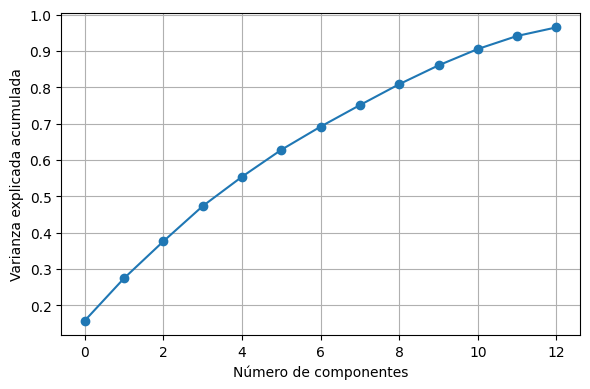

Componentes usados: 13


In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

explained = pca.explained_variance_ratio_.cumsum()
plt.figure(figsize=(6, 4))
plt.plot(explained, marker="o")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza explicada acumulada")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Componentes usados:", X_train_pca.shape[1])



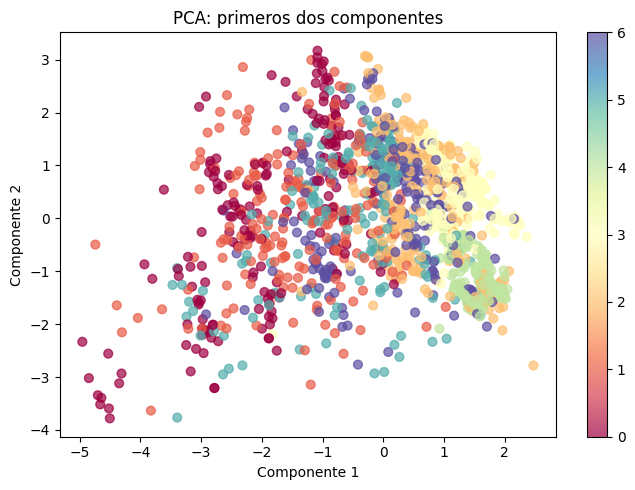

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="Spectral", s=40, alpha=0.7)
ax.set_title("PCA: primeros dos componentes")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
plt.colorbar(scatter, ax=ax, ticks=range(len(y_train.unique())))
plt.tight_layout()
plt.show()



## 03. t-SNE (visualización)
Aplicamos t-SNE a una muestra de 1.000 registros para visualizar agrupamientos. No se utiliza directamente para entrenar modelos finales.


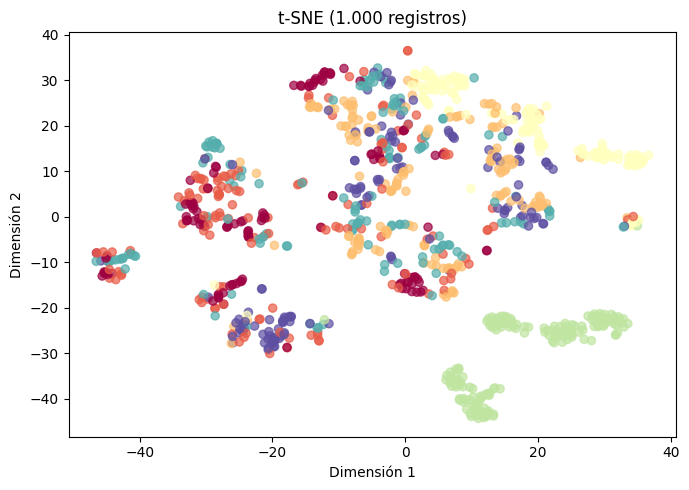

In [37]:
from sklearn.manifold import TSNE

sample = X_train.sample(1000, random_state=42)
sample_y = y_train.loc[sample.index]
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate="auto")
coords = tsne.fit_transform(sample)

fig, ax = plt.subplots(figsize=(7, 5))
scatter = ax.scatter(coords[:, 0], coords[:, 1], c=sample_y, cmap="Spectral", s=35, alpha=0.7)
ax.set_title("t-SNE (1.000 registros)")
ax.set_xlabel("Dimensión 1")
ax.set_ylabel("Dimensión 2")
plt.tight_layout()
plt.show()



## 04. UMAP
Probar diversas combinaciones de `n_neighbors` y `min_dist`, visualizar y preparar transformaciones que puedan alimentar modelos reducidos.


c:\Users\GARCÍA\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


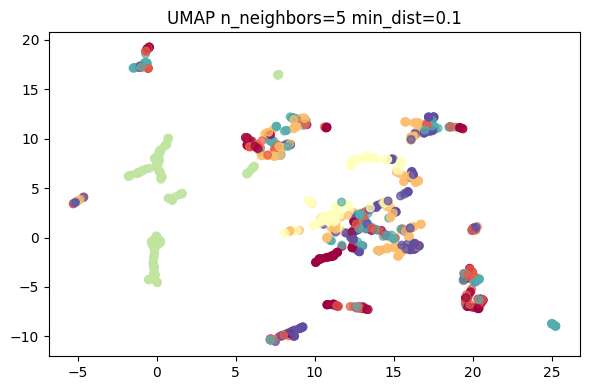

c:\Users\GARCÍA\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


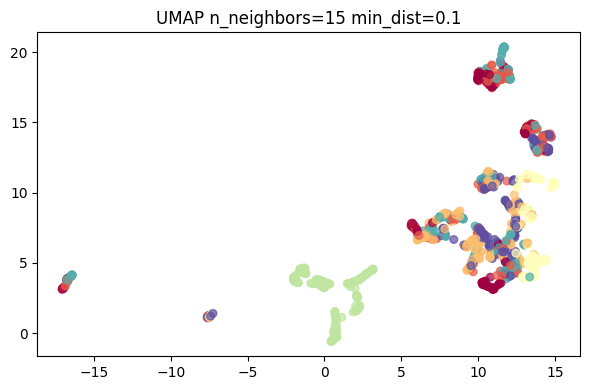

c:\Users\GARCÍA\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


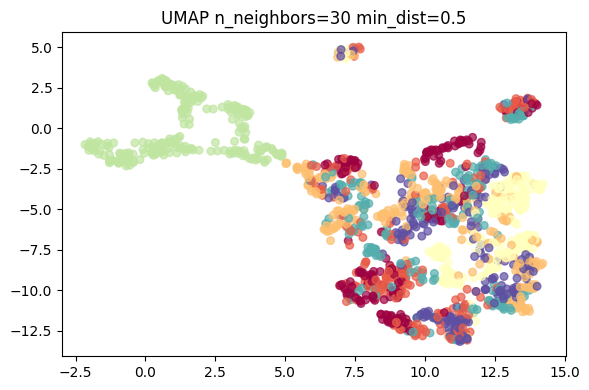

In [38]:
from sklearn.utils import check_array as _sk_check_array
import umap.umap_ as _umap_module

def _check_array_compat(*args, **kwargs):
    kwargs.pop("ensure_all_finite", None)
    return _sk_check_array(*args, **kwargs)

_umap_module.check_array = _check_array_compat

umap_configs = [
    {"n_neighbors": 5, "min_dist": 0.1},
    {"n_neighbors": 15, "min_dist": 0.1},
    {"n_neighbors": 30, "min_dist": 0.5}
]
umap_models = []
for cfg in umap_configs:
    reducer = umap.UMAP(n_components=2, random_state=42, **cfg)
    embedding = reducer.fit_transform(X_train)
    umap_models.append((cfg, reducer, embedding))
    fig, ax = plt.subplots(figsize=(6, 4))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=y_train, cmap="Spectral", s=30, alpha=0.7)
    ax.set_title(f"UMAP n_neighbors={cfg['n_neighbors']} min_dist={cfg['min_dist']}")
    plt.tight_layout()
    plt.show()

## 05. Comparación de modelos con y sin reducción
Entrenar los mejores modelos del notebook 03 (por ejemplo, GradientBoosting y SVM) sobre las representaciones originales, PCA y UMAP y comparar MAE/accuracy.


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, accuracy_score

models = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", probability=False, class_weight="balanced")
}

umap_reducer = umap_models[1][1] if len(umap_models) > 1 else None
X_train_umap = umap_reducer.transform(X_train) if umap_reducer else None
X_test_umap = umap_reducer.transform(X_test) if umap_reducer else None

def eval_model(model, X_tr, X_te):
    model.fit(X_tr, y_train)
    pred = model.predict(X_te)
    return {
        "mae": mean_absolute_error(y_test, pred),
        "accuracy": accuracy_score(y_test, pred)
    }

records = []
for name, clf in models.items():
    dataset_map = [
        ("Original", (X_train, X_test)),
        ("PCA", (X_train_pca, X_test_pca))
    ]
    if umap_reducer is not None:
        dataset_map.append(("UMAP", (X_train_umap, X_test_umap)))
    for label, (X_tr, X_te) in dataset_map:
        metrics = eval_model(clf, X_tr, X_te)
        records.append({"modelo": name, "reduccion": label, **metrics})

results_red = pd.DataFrame(records)
results_red



,modelo,reduccion,mae,accuracy
0,GradientBoosting,Original,0.047319,0.971609
1,GradientBoosting,PCA,0.414826,0.839117
2,GradientBoosting,UMAP,0.968454,0.664038
3,SVM,Original,0.343849,0.878549
4,SVM,PCA,0.378549,0.869085
5,SVM,UMAP,1.332808,0.541009


## 06. Tabla comparativa para el informe
Se resume el impacto de cada técnica (Original, PCA y UMAP) en MAE y accuracy para los modelos evaluados

In [ ]:
summary = results_red.pivot_table(index='reduccion', columns='modelo', values=['mae', 'accuracy'])
summary = summary.swaplevel(0, 1, axis=1)
summary = summary.sort_index(axis=1)
summary = summary.round(4)

display(summary)


modelo    GradientBoosting              SVM        
                  accuracy     mae accuracy     mae
reduccion                                          
Original            0.9716  0.0473   0.8785  0.3438
PCA                 0.8391  0.4148   0.8691  0.3785
UMAP                0.6640  0.9685   0.5410  1.3328

Tabla guardada en results/tablas/reduction_comparison.csv
